In [24]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

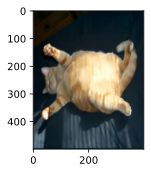

In [25]:
d2l.set_figsize()
img = d2l.Image.open('./img/cat1.jpg')
d2l.plt.imshow(img)

In [26]:
#参数aug表示数据增广的模型，参数scale表示图像的缩放比例。它用于调整显示图像时的尺寸大小，以便在显示多个图像时能够更好地查看它们
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y,num_rows,num_cols,scale=scale)

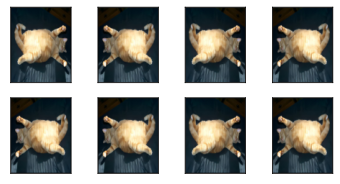

In [27]:
#使用transforms模块来创建RandomFlipLeftRight实例，这样就各有50%的几率使图像向左或向右翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

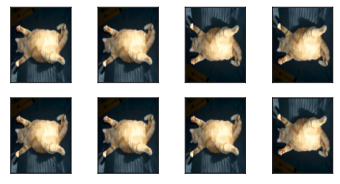

In [28]:
#使用transforms模型中的上下反转
apply(img, torchvision.transforms.RandomVerticalFlip())

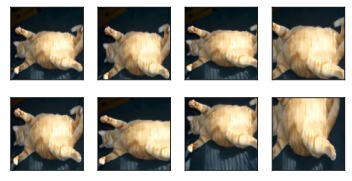

In [29]:
#代码将随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

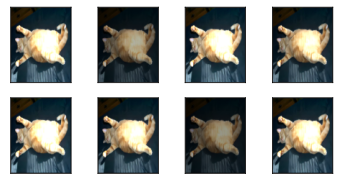

In [30]:
#改变颜色，可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调。 在下面的示例中，我们随机更改图像的亮度，随机值为原始图像的50%(1-0.5）到150%(1+0.5)之间,brightness（亮度），contrast（对比度），saturation（饱和度），hue（色调）
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

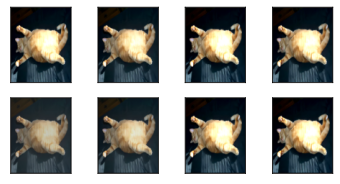

In [31]:
#改变对比度
apply(img, torchvision.transforms.ColorJitter(brightness=0,contrast=0.5,saturation=0,hue=0))

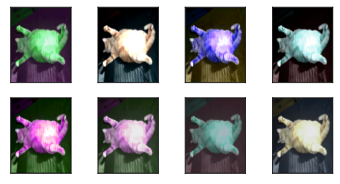

In [32]:
#创建一个RandomColorJitter实例，并设置如何同时随机更改图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

100.0%


Extracting .//data\cifar-10-python.tar.gz to .//data


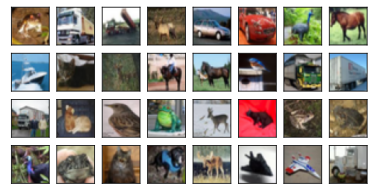

In [38]:
#使用CIFAR-10数据集运用图像增广进行训练
all_images = torchvision.datasets.CIFAR10(train=True, root=".//data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

#URLError: <urlopen error [Errno 2] No such file or directory>是因为没有搭建正确的vpn，使用美国的服务器成功

In [39]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()]) #使用ToTensor实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [41]:
def load_cifar10(is_train, augs, batch_size):  #我们定义一个辅助函数，以便于读取图像和应用图像增广。PyTorch数据集提供的transform参数应用图像增广来转化图像
    dataset = torchvision.datasets.CIFAR10(root=".//data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [42]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [43]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 2.00 GiB total capacity; 557.69 MiB already allocated; 473.72 MiB free; 610.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

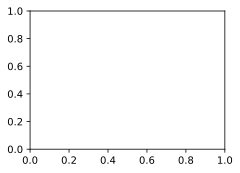

In [44]:
train_with_data_aug(train_augs, test_augs, net)